# Dogs vs. Cats
Create an algorithm to distinguish dogs from cats
- Kaggle Link : https://www.kaggle.com/c/dogs-vs-cats
- Referred Notebook Link : https://www.kaggle.com/bulentsiyah/dogs-vs-cats-classification-vgg16-fine-tuning

이미지 처리 및 분류 모델 구축 프로세스를 익히기 위해 위 코드 내용을 따라하며 공부한 내용입니다. 


> 새로 알게된 내용 : VGG16 Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
print(os.listdir("./data"))

['sampleSubmission.csv', 'test1', 'train']


# Prepare Training Data

In [2]:
filenames = os.listdir('./data/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    elif category == 'cat':
        categories.append(0)

df = pd.DataFrame({'filename':filenames, 'category':categories})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [3]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

# See Sample Image

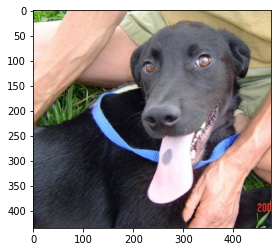

In [4]:
sample = random.choice(filenames)
image = load_img('./data/train/'+sample)
plt.imshow(image)

# Build Model
- VGG16
  - 미리 학습된 모델
  - VGG 뒤에 붙은 숫자는 레이어의 개수로, VGG16은 16개의 레이어를 가진다.
  - VGG16의 모든 필터는 3*3, stride=1으로 설정되어 있다.
  - 또한 모든 레이어의 활성화 함수로 ReLU를 사용한다.
  - [참고 블로그](https://daechu.tistory.com/10)
<hr />

- 두 가지 방식이 있다.
  1. 새로운 데이터셋에서 VGG16을 실행하여 `model.predict()` 의 방법으로 출력을 저장한다. 이렇게 되면 VGG16의 Densely Connected Layer를 지나지 않은 Convolution만 지난 값들을 Fully Connected Layer에 입력으로 사용한다. \
    이 방식은 합성곱 연산을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 들지만, 데이터 증식을 사용할 수 없다.
  2. 새로운 `model.Sequential()`을 만들고 그 모델에 VGG16을 넣고 이후에 Densly Connected Layer를 쌓아서 확장한다. \
    그 다음 입력데이터에서 end-to-end로 전체 모델을 실행하는데, weight 값을 처음부터 구하지 않도록 모델을 freezing 해서 computational cost를 줄인다. \
    모델에 노출된 모든 입력 이미지가 매번 합성곱 기반 층을 통과하기에 데이터 증식을 사용할 수 있다. but cost가 많이 든다.

    
  여기서는 2번 방식을 사용한다. \
  모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 freezing 하는 것이 중요하다. \
  Layer를 freezing하는 것은 훈련하는 동안 layer의 weight가 업데이트되는 것을 막는 것이다. \
  이를 통해서 Convolution base에 의해서 train되었던 것들이 수정될 것이다. \
  Keras에서는 trainable이라는 속성을 False로 설정해서 네트워크를 Freeze할 수 있다. 





In [34]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras import applications
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from keras.models import Model

In [35]:
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape = input_shape, include_top=False, weights='imagenet')

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
pre_trained_model.layers

In [30]:
pre_trained_model.layers[15:]

In [17]:
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [23]:
#Flatten the output to 1 dimentsion
x = GlobalMaxPooling2D()(last_output)
#Add a fully connected layer with 512 units and ReLu activation
x = Dense(512, activation='relu')(x)
#Add a dropout
x = Dropout(0.5)(x)
#final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Prepare Test and Train data

In [24]:
train_df, valid_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
valid_df = valid_df.reset_index()

total_train = train_df.shape[0]
total_validate = valid_df.shape[0]

# Training Generator

In [26]:
train_df['category'] = train_df['category'].astype('str')
valid_df['category'] = valid_df['category'].astype('str')

In [27]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(train_df, './data/train/', x_col='filename', y_col='category', class_mode='binary',
                                                    target_size=(image_size, image_size), batch_size=batch_size)

Found 22500 validated image filenames belonging to 2 classes.


# Validation Generator

In [28]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(valid_df, './data/train/', x_col='filename', y_col='category', class_mode='binary',
                                                    target_size=(image_size, image_size), batch_size=batch_size)

Found 2500 validated image filenames belonging to 2 classes.


# Fit Model

In [29]:
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, validation_steps=total_validate//batch_size, steps_per_epoch=total_train//batch_size)

Epoch 1/5
  44/1406 [..............................] - ETA: 1:51:23 - loss: 0.5432 - accuracy: 0.7216

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(valid_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f ; loss = %f" % (accuracy, loss))

In [ ]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

# Prepare Testing Data

In [ ]:
test_filenames = os.listdir("./data/test1")
test_df = pd.DataFrame({'filename': test_filenames})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, "./data/test1/", x_col='filename', y_col=None,
                                              class_mode=None, batch_size=batch_size, target_size=(image_size, image_size), shuffle=False)

# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)